In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import gym

### set up environment

In [2]:
env = gym.make('CartPole-v0')
#get dimension of action and state
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
#whether use cuda
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() \
            if USE_CUDA else autograd.Variable(*args, **kwargs)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### experience replay

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

### epsilon-greedy policy
DQN is an off-policy algorithm, the policy it applies is epsilon-greedy with decay.

```
if random.random() < epsilon_by_frame:
    action = np.random.randint(0, N_ACTIONS)
else:
    output = model.forward(s)
    action = torch.max(output.data, 1)[1].cpu().numpy()[0]
```

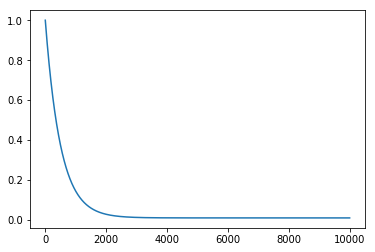

In [4]:
import math
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final +\
            (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
#plot epsilon along time axis
plt.plot([epsilon_by_frame(i) for i in range(10000)])


### Q-Network

In [5]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action
    
current_model = DQN(N_STATES, N_ACTIONS) #Q-network
target_model  = DQN(N_STATES, N_ACTIONS) #target Q-network

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

#sychronize current Q network and target Q network
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
#initialize target action-value function
update_target(current_model, target_model)

### train and plot loss

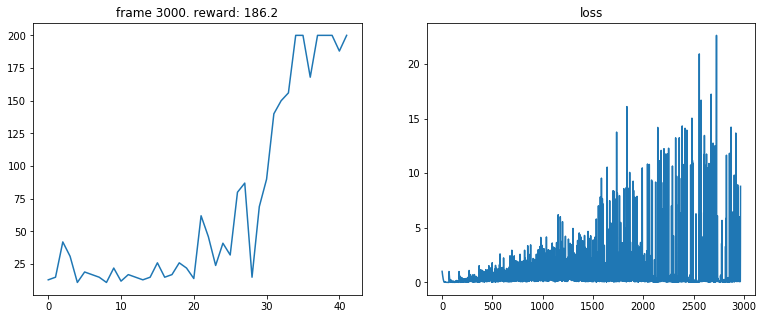

In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

num_frames = 10000
batch_size = 32
gamma      = 0.99 #discount factor

losses = []
all_rewards = []
episode_reward = 0

#get init state
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    #get decayed epsilon for greedy policy
    epsilon = epsilon_by_frame(frame_idx)
    #get off-policy action according to the greedy policy
    action = current_model.act(state, epsilon)
    #get s2, r, terminal signal from env
    next_state, reward, done, _ = env.step(action)
    #add the sequence to replay buffer
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)        
        losses.append(loss.data[0])
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)

In [20]:
state, action, reward, next_state, done = replay_buffer.sample(batch_size)
action = Variable(torch.LongTensor(action))
state = Variable(torch.FloatTensor(np.float32(state)))
next_state = state
q_values      = current_model(state)
next_q_values = current_model(next_state)
next_q_state_values = target_model(next_state) 
print(q_values.size())
q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 

next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)

torch.Size([32, 2])


In [23]:
print(next_q_values, torch.max(next_q_values, 1)[1])

Variable containing:
 67.9777  66.8479
 71.2901  70.4211
 50.7667  49.8153
 67.6696  65.1575
 66.2754  65.0551
 66.0648  66.2497
 60.7599  58.4430
 68.6748  68.2351
 55.2913  52.6305
 68.7713  68.0236
 72.3712  71.8736
 55.3100  54.4517
 68.9036  68.1504
 52.4153  51.8044
 64.1511  62.2921
 47.6843  46.5575
 61.5797  60.2663
 51.8566  49.3192
 67.9045  67.6648
 56.6471  53.6796
 65.6915  65.8557
 67.9942  66.1583
 67.6651  66.4953
 68.6014  67.6497
 66.4205  65.7009
 62.0975  60.8206
 68.2126  67.4831
 61.3587  59.0007
 73.6557  72.0429
 55.5288  55.4896
 53.1264  51.2341
 64.3598  62.5724
[torch.cuda.FloatTensor of size 32x2 (GPU 0)]
 Variable containing:
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.cuda.LongTensor of size 32 (GPU 0)]



### for visual Input
* set up environments
* create Q network
* train

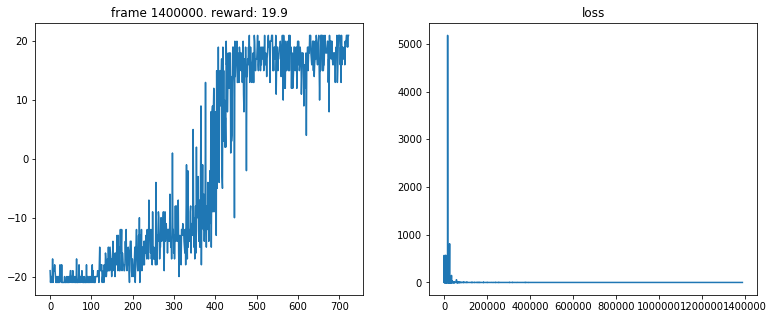

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import gym
import math
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
import random

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() \
            if USE_CUDA else autograd.Variable(*args, **kwargs)


from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model = CnnDQN(env.observation_space.shape, env.action_space.n)
if USE_CUDA:
    current_model = current_model.cuda()
    target_model = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)
update_target(current_model, target_model)
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)